In [1]:
#Group Root
#Group Member
#1. CHONG KEE YEW 22099549
#2. XU CHANGFENG 23054770
#3. SHENG YUAN 22118773
#Course: WOA7015 Advanced Machine Learning
#Lecturer: Dr Saw Shier Nee
#Semester 1 2024/2025

In [2]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import re
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_curve, auc, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
from itertools import product
import itertools
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

warnings.simplefilter(action='ignore', category=FutureWarning)

cuda


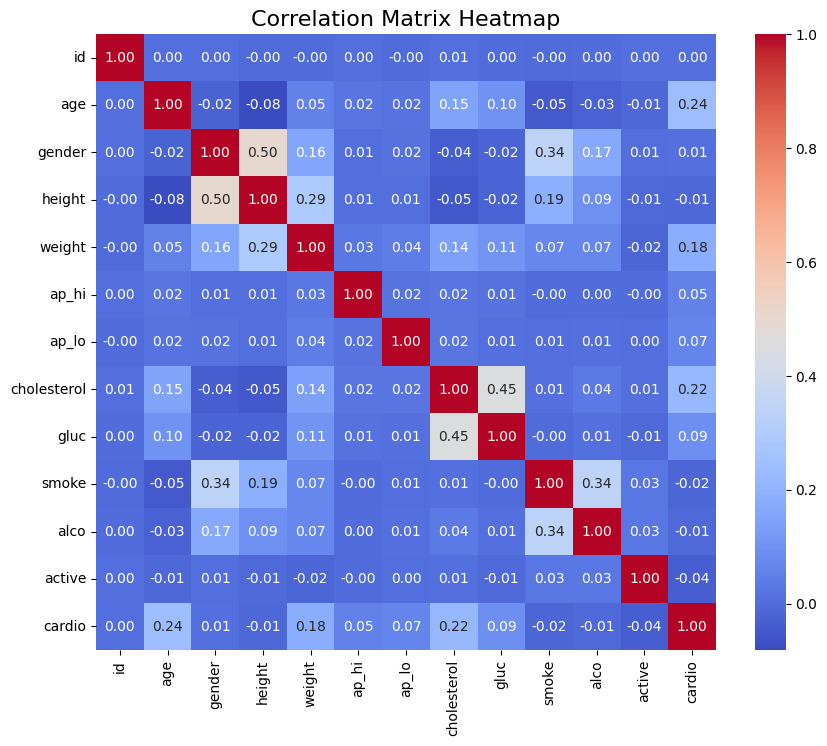

In [4]:
data = pd.read_csv('cardio.csv', delimiter=';')

pd.set_option("display.max_columns", None)

correlation_matrix = data.corr()

#HeatMap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

In [5]:
# Step1 Check Null Values
null_values = data.isnull().sum()
print("Null values in each column:")
print(null_values)

Null values in each column:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [6]:
# Step2 Check Duplicate Values
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [7]:
# Step 3: Drop unique identifier column
data = data.drop(columns=['id'])

# Step 4: Replace 1 to 0, 2 to 1 for Gender Column
# 1 is women, 2 is men
data['gender'] = data['gender'].replace({1: 0, 2: 1})

In [8]:
# Step 5: Feature Engineering
# Add BMI and BMI Category
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:    
        return "Overweight"
    else:                   
        return "Obese"

data["height_m"] = data["height"] / 100
data["bmi"] = data["weight"] / (data["height_m"] ** 2)
data["bmi"] = data["bmi"].apply(lambda x: round(x, 2))
data.drop(columns=["height_m"], inplace=True)
data["bmi_category"] = data["bmi"].apply(categorize_bmi)
print(data[["weight", "height", "bmi", "bmi_category"]].head())

bmi_category_counts = data['bmi_category'].value_counts()
print("\n", bmi_category_counts)

   weight  height    bmi bmi_category
0    62.0     168  21.97       Normal
1    85.0     156  34.93        Obese
2    64.0     165  23.51       Normal
3    82.0     169  28.71   Overweight
4    56.0     156  23.01       Normal

 bmi_category
Normal         25656
Overweight     25175
Obese          18525
Underweight      644
Name: count, dtype: int64


In [9]:
# Step 6: Encoding
categorical_features = ['cholesterol', 'gluc', 'bmi_category']
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(data[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names)
encoded_data = pd.concat([data, encoded_df], axis=1).drop(columns=categorical_features)

In [10]:
# Step 7: Scaling
scaler = MinMaxScaler()
columns = encoded_data.columns.tolist()
scaled_data = scaler.fit_transform(encoded_data)
scaled_df = pd.DataFrame(scaled_data, columns=columns)

In [11]:
print(scaled_df.head(5))
print(scaled_df.dtypes)

        age  gender    height    weight     ap_hi     ap_lo  smoke  alco  \
0  0.588076     1.0  0.579487  0.273684  0.016079  0.013550    0.0   0.0   
1  0.730159     0.0  0.517949  0.394737  0.017934  0.014453    0.0   0.0   
2  0.624003     0.0  0.564103  0.284211  0.017316  0.012647    0.0   0.0   
3  0.528455     1.0  0.584615  0.378947  0.018553  0.015357    0.0   0.0   
4  0.516918     0.0  0.517949  0.242105  0.015461  0.011743    0.0   0.0   

   active  cardio       bmi  cholesterol_1  cholesterol_2  cholesterol_3  \
0     1.0     0.0  0.062669            1.0            0.0            0.0   
1     1.0     1.0  0.106572            0.0            0.0            1.0   
2     0.0     1.0  0.067886            0.0            0.0            1.0   
3     1.0     1.0  0.085501            1.0            0.0            0.0   
4     0.0     0.0  0.066192            1.0            0.0            0.0   

   gluc_1  gluc_2  gluc_3  bmi_category_Normal  bmi_category_Obese  \
0     1.0     0.

In [12]:
#Dataset Split
X = scaled_df.drop('cardio', axis=1).values
y = scaled_df['cardio'].astype(int).values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 56000
Validation set size: 7000
Test set size: 7000


In [13]:
# Check 0 and 1 Distribution
def check_distribution(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Distribution in {set_name} set (cardio): {distribution}")

check_distribution(y_train, "training")
check_distribution(y_val, "validation")
check_distribution(y_test, "test")

Distribution in training set (cardio): {0: 28033, 1: 27967}
Distribution in validation set (cardio): {0: 3489, 1: 3511}
Distribution in test set (cardio): {0: 3499, 1: 3501}


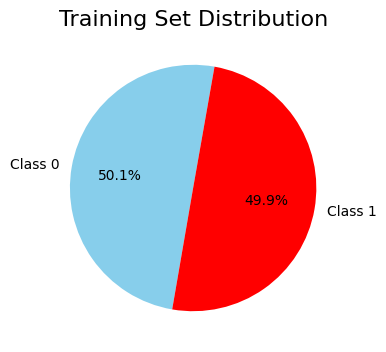

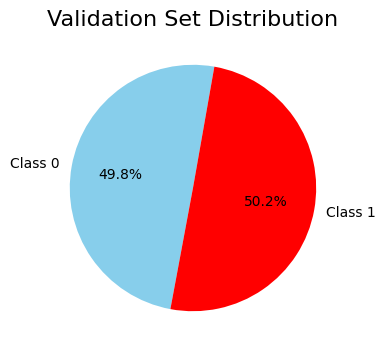

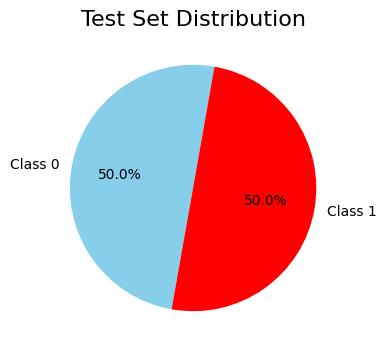

In [14]:
#plot distribution set pie chart
def plot_pie_chart(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    labels = [f"Class {label}" for label in unique]
    plt.figure(figsize=(4, 4))
    plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=80, colors=["skyblue", "red"])
    plt.title(f"{set_name} Set Distribution", fontsize=16)
    plt.show()

plot_pie_chart(y_train, "Training")
plot_pie_chart(y_val, "Validation")
plot_pie_chart(y_test, "Test")

In [15]:
#Custom Dataset
class CardioCustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32) 
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [16]:
# Initiate DataLoader
train_dataset = CardioCustomDataset(X_train, y_train)
val_dataset = CardioCustomDataset(X_val, y_val)
test_dataset = CardioCustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 1750
Validation batches: 219
Test batches: 219


In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, dropout=0.2):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden1)  
        self.fc2 = nn.Linear(hidden1, hidden2)    
        self.fc3 = nn.Linear(hidden2, 1)         
        
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = torch.sigmoid(self.fc3(x))
        return x

In [18]:
#MLP + Simple Attention
class MLP_SimpleAttention(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, attention_size):
        super(MLP_SimpleAttention, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        
        self.attention = nn.Linear(input_size, attention_size)
        self.context_vector = nn.Linear(attention_size, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention_weights = torch.tanh(self.attention(x))  
        attention_weights = self.context_vector(attention_weights)  
        attention_weights = torch.softmax(attention_weights, dim=-1)  
        
        attended_x = x * attention_weights

        x = torch.relu(self.fc1(attended_x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [19]:
#MLP + MultiHeadAttention
class MLP_MultiHeadAttention(nn.Module):
    def __init__(self, input_size, num_heads, head_dim, hidden_size1, hidden_size2):
        super(MLP_MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.input_size = input_size

        self.query = nn.Linear(input_size, num_heads * head_dim)
        self.key = nn.Linear(input_size, num_heads * head_dim)
        self.value = nn.Linear(input_size, num_heads * head_dim)

        self.out = nn.Linear(num_heads * head_dim, input_size)

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim)

        scores = torch.einsum('bhqd,bhkd->bhqk', Q, K) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(scores, dim=-1)

        attended = torch.einsum('bhqk,bhvd->bhqd', attention_weights, V)
        attended = attended.reshape(batch_size, -1, self.num_heads * self.head_dim)

        attended = self.out(attended)

        x = torch.relu(self.fc1(attended))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x)).squeeze(-1)
        return x


In [20]:
#MLP + Pairwise Attention
class MLP_PairwiseAttention(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, interaction_dim):
        super(MLP_PairwiseAttention, self).__init__()
        
        self.input_size = input_size
        self.interaction_dim = interaction_dim

        self.interaction_layer = nn.Linear(input_size * input_size, interaction_dim)
        
        self.fc1 = nn.Linear(input_size + interaction_dim, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        interactions = torch.bmm(x.unsqueeze(2), x.unsqueeze(1))
        interactions = interactions.view(batch_size, -1)
        
        interaction_scores = self.interaction_layer(interactions)

        combined = torch.cat([x, interaction_scores], dim=1)

        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x)).squeeze(-1)
        return x


In [21]:
#Feature size
input_size = X.shape[1]
epochs = 1000

#Early stopping size
patience = 5

#Models Dictionary
models = {
    "MLP": lambda input_size, params: MLP(input_size, params["hidden_size1"], params["hidden_size2"]),
    #attetion_size = 4 - 10
    "MLP + Simple Attention": lambda input_size, params: MLP_SimpleAttention(
        input_size, params["hidden_size1"], params["hidden_size2"], attention_size=4
    ),
    #num_heads * head_dim = input size
    "MLP + Multi-Head Attention": lambda input_size, params: MLP_MultiHeadAttention(
        input_size, num_heads=4, head_dim=5, hidden_size1=params["hidden_size1"], hidden_size2=params["hidden_size2"]
    ),
    #interaction_dim = 4 - 10
    "MLP + Pairwise Attention": lambda input_size, params: MLP_PairwiseAttention(
        input_size, params["hidden_size1"], params["hidden_size2"], interaction_dim=4
    ),
}

#Grid Dictionary
param_grid = {
    "hidden_size1": [12, 16],
    "hidden_size2": [6, 8],
    "learning_rate": [0.001, 0.003]
}

#Best Models
best_val_loss = {model_name: float('inf') for model_name in models.keys()}
best_params = {model_name: None for model_name in models.keys()}
best_model_states = {model_name: None for model_name in models.keys()}

for model_name, model_fn in models.items():
    for params in product(*param_grid.values()):
        param_names = list(param_grid.keys())
        config = dict(zip(param_names, params))
        
        print(f"Evaluating model: {model_name}")
        print(f"Model Parameters: {config}")

        input_size = X_train.shape[1]
        model = model_fn(input_size, config).to(device)

        #Loss and Optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

        best_model_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False

        for epoch in range(epochs):
            if early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

            #Training
            model.train()
            train_loss = 0.0
            for batch_features, batch_labels in train_loader:
                
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)
                
                if model_name == 'MLP + Pairwise Attention':
                    batch_labels = batch_labels.view(-1, 1).squeeze()
                else:
                    batch_labels = batch_labels.view(-1, 1)
                
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()

            #Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_features, val_labels in val_loader:
                    
                    val_features = val_features.to(device)
                    val_labels = val_labels.to(device)
                    
                    if model_name == 'MLP + Pairwise Attention':
                        val_labels = val_labels.view(-1, 1).squeeze()
                    else:
                        val_labels = val_labels.view(-1, 1)
                        
                    val_outputs = model(val_features)
                    val_loss += criterion(val_outputs, val_labels).item()

            #Early stopping Logic
            if val_loss < best_model_val_loss:
                best_model_val_loss = val_loss  
                epochs_no_improve = 0  
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    early_stop = True
                    
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

        #Save Model
        if best_model_val_loss < best_val_loss[model_name]:
            best_val_loss[model_name] = best_model_val_loss
            best_params[model_name] = config
            best_model_states[model_name] = model.state_dict()

#Best Hyperparam print
print("\nBest Hyperparameters:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

Evaluating model: MLP
Model Parameters: {'hidden_size1': 12, 'hidden_size2': 6, 'learning_rate': 0.001}
Epoch 10, Train Loss: 0.6383, Val Loss: 0.6261
Epoch 20, Train Loss: 0.6352, Val Loss: 0.6240
Epoch 30, Train Loss: 0.6335, Val Loss: 0.6217
Early stopping triggered at epoch 37
Evaluating model: MLP
Model Parameters: {'hidden_size1': 12, 'hidden_size2': 6, 'learning_rate': 0.003}
Epoch 10, Train Loss: 0.6378, Val Loss: 0.6297
Epoch 20, Train Loss: 0.6371, Val Loss: 0.6256
Early stopping triggered at epoch 25
Evaluating model: MLP
Model Parameters: {'hidden_size1': 12, 'hidden_size2': 8, 'learning_rate': 0.001}
Epoch 10, Train Loss: 0.6357, Val Loss: 0.6280
Epoch 20, Train Loss: 0.6339, Val Loss: 0.6258
Epoch 30, Train Loss: 0.6317, Val Loss: 0.6216
Epoch 40, Train Loss: 0.6289, Val Loss: 0.6181
Epoch 50, Train Loss: 0.6213, Val Loss: 0.6099
Epoch 60, Train Loss: 0.6057, Val Loss: 0.5802
Early stopping triggered at epoch 70
Evaluating model: MLP
Model Parameters: {'hidden_size1': 12,


Test Set Evaluation with MLP

MLP Test Accuracy: 0.6967

Classification Report:
              precision    recall  f1-score   support

   No Cardio       0.65      0.84      0.74      3499
      Cardio       0.78      0.55      0.64      3501

    accuracy                           0.70      7000
   macro avg       0.72      0.70      0.69      7000
weighted avg       0.72      0.70      0.69      7000



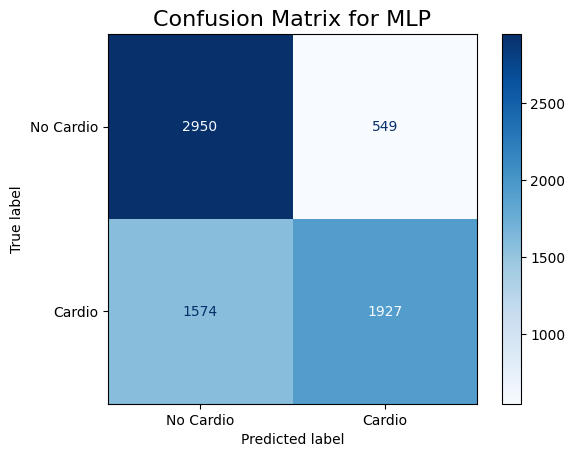


Test Set Evaluation with MLP + Simple Attention

MLP + Simple Attention Test Accuracy: 0.7036

Classification Report:
              precision    recall  f1-score   support

   No Cardio       0.67      0.80      0.73      3499
      Cardio       0.76      0.60      0.67      3501

    accuracy                           0.70      7000
   macro avg       0.71      0.70      0.70      7000
weighted avg       0.71      0.70      0.70      7000



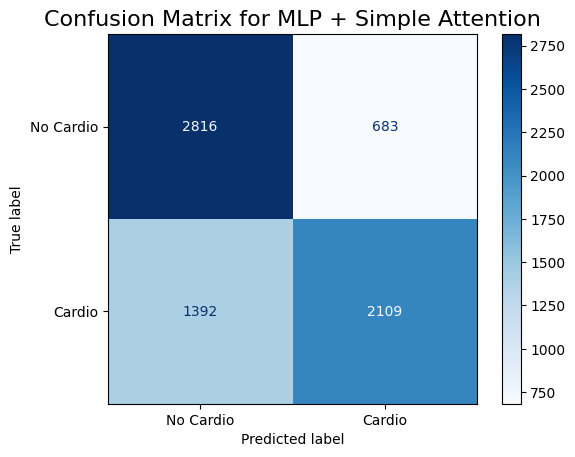


Test Set Evaluation with MLP + Multi-Head Attention

MLP + Multi-Head Attention Test Accuracy: 0.6980

Classification Report:
              precision    recall  f1-score   support

   No Cardio       0.65      0.85      0.74      3499
      Cardio       0.78      0.55      0.64      3501

    accuracy                           0.70      7000
   macro avg       0.72      0.70      0.69      7000
weighted avg       0.72      0.70      0.69      7000



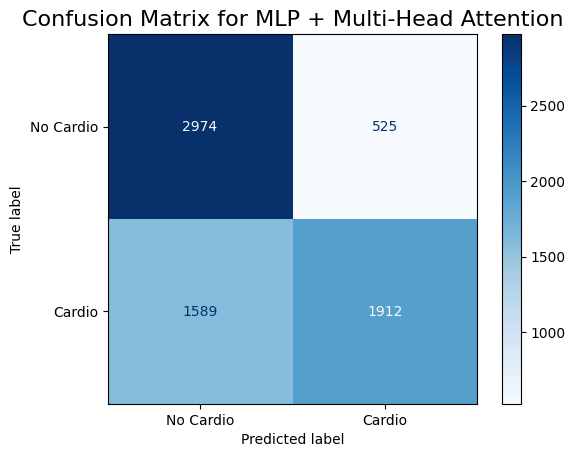


Test Set Evaluation with MLP + Pairwise Attention

MLP + Pairwise Attention Test Accuracy: 0.7173

Classification Report:
              precision    recall  f1-score   support

   No Cardio       0.74      0.68      0.71      3499
      Cardio       0.70      0.76      0.73      3501

    accuracy                           0.72      7000
   macro avg       0.72      0.72      0.72      7000
weighted avg       0.72      0.72      0.72      7000



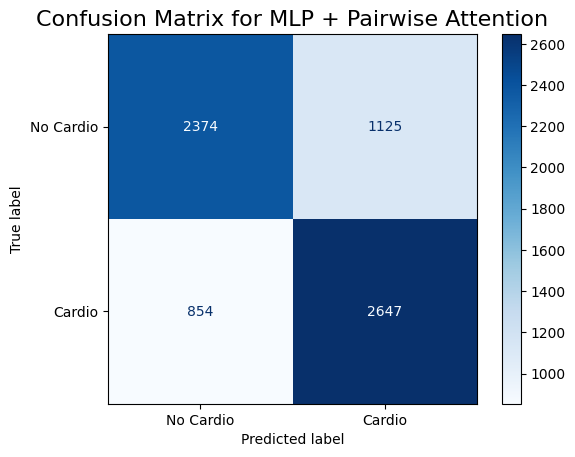

In [22]:
test_accuracies = {}
model_metrics = {model_name: {} for model_name in models.keys()}

#Test Set Evaluation
for model_name, model_fn in models.items():
    print(f"\nTest Set Evaluation with {model_name}")

    best_model = model_fn(input_size, best_params[model_name]).to(device)
    best_model.load_state_dict(best_model_states[model_name])
    best_model.eval()

    all_test_labels = []
    all_test_predictions = []
    all_test_probabilities = []
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_features, test_labels in test_loader:

            test_features = test_features.to(device)
            test_labels = test_labels.to(device)
            
            test_outputs = best_model(test_features).squeeze()
            test_predictions = (test_outputs > 0.5).int()
            
            all_test_labels.extend(test_labels.cpu().squeeze().numpy())
            all_test_predictions.extend(test_predictions.cpu().numpy())
            all_test_probabilities.extend(test_outputs.cpu().numpy()) 
            test_correct += (test_predictions == test_labels.squeeze().int()).sum().item()
            test_total += test_labels.size(0)

    test_accuracy = test_correct / test_total
    test_accuracies[model_name] = test_accuracy

    #Classification Report
    print(f"\n{model_name} Test Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_test_labels, all_test_predictions, target_names=["No Cardio", "Cardio"]))

    #Classification Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_test_labels, all_test_predictions, average="binary"
    )
    
    #ROC Curve
    fpr, tpr, _ = roc_curve(all_test_labels, all_test_probabilities)
    roc_auc = auc(fpr, tpr)

    model_metrics[model_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_curve": (fpr, tpr),
        "roc_auc": roc_auc,
    }

    #Confusion Matrix
    conf_m = confusion_matrix(all_test_labels, all_test_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=["No Cardio", "Cardio"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix for {model_name}", fontsize=16)
    plt.show()

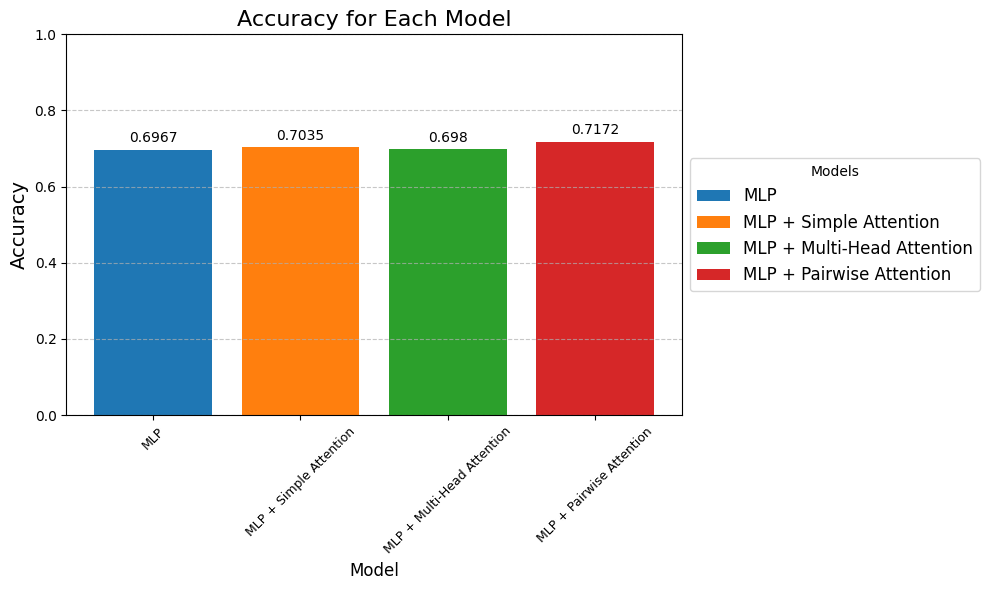

In [23]:
#Accuracy Plot
colors = cm.tab10(range(len(test_accuracies)))

plt.figure(figsize=(10, 6))

bars = []
for i, (model_name, accuracy) in enumerate(test_accuracies.items()):
    bar = plt.bar(model_name, accuracy, color=colors[i], label=model_name)
    bars.append(bar)

plt.title("Accuracy for Each Model", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=9)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar[0].get_height()
    trimmed_height = str(height)[:6]
    plt.text(bar[0].get_x() + bar[0].get_width() / 2.0, height + 0.02, trimmed_height, ha='center', fontsize=10)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

plt.tight_layout()
plt.show()

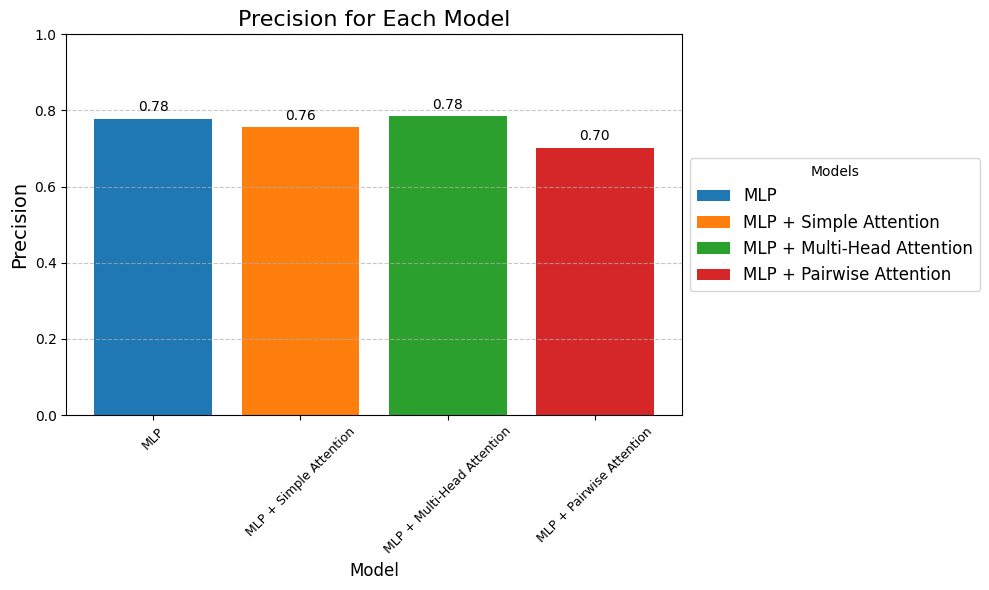

In [24]:
#Precision Plot
plt.figure(figsize=(10, 6))
bars = []
for model_name, metrics in model_metrics.items():
    bar = plt.bar(model_name, metrics["precision"], label=f"{model_name}")
    bars.append(bar)

plt.ylabel("Precision", fontsize=14)
plt.title("Precision for Each Model", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)


for bar in bars:
    for rect in bar:
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width() / 2.0,
            height + 0.02,  
            f'{height:.2f}', 
            ha='center', 
            fontsize=10
        )

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

plt.tight_layout()
plt.show()

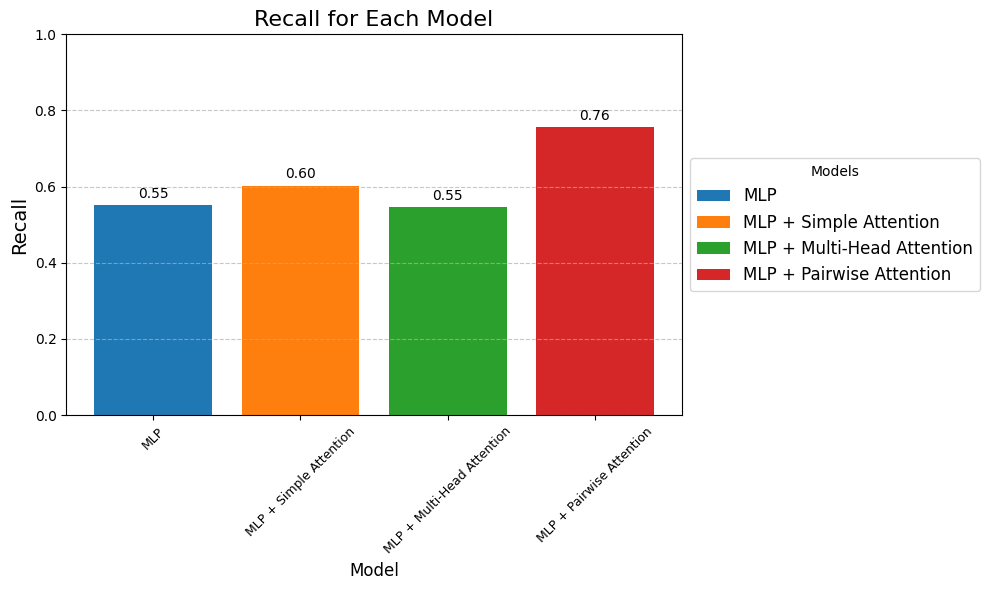

In [25]:
#Precision Plot
plt.figure(figsize=(10, 6))
bars = []
for model_name, metrics in model_metrics.items():
    bar = plt.bar(model_name, metrics["recall"], label=f"{model_name}")
    bars.append(bar)

plt.ylabel("Recall", fontsize=14)
plt.title("Recall for Each Model", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)


for bar in bars:
    for rect in bar:
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width() / 2.0,
            height + 0.02,  
            f'{height:.2f}', 
            ha='center', 
            fontsize=10
        )

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

plt.tight_layout()
plt.show()

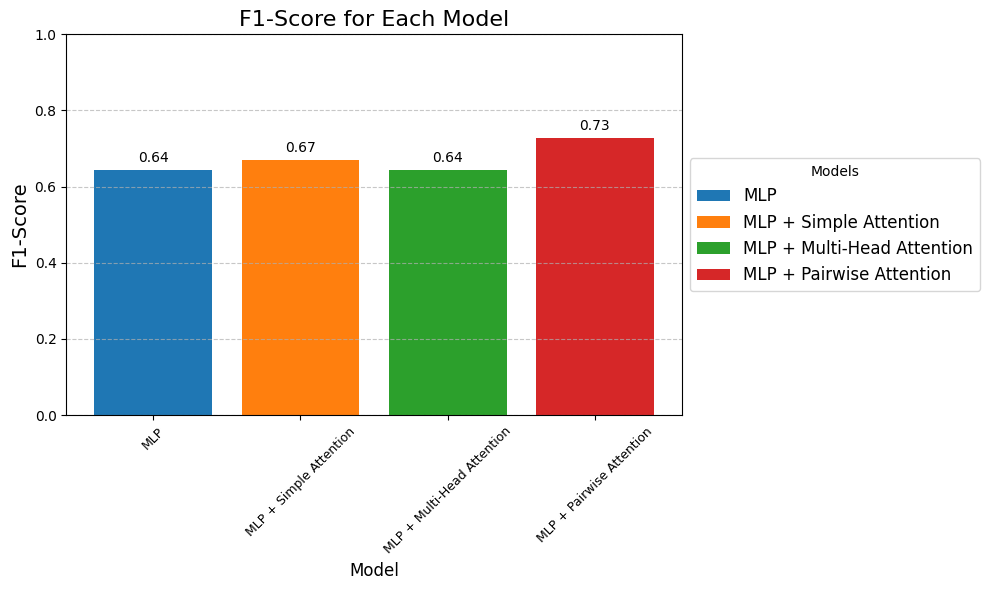

In [26]:
#Precision Plot
plt.figure(figsize=(10, 6))
bars = []
for model_name, metrics in model_metrics.items():
    bar = plt.bar(model_name, metrics["f1_score"], label=f"{model_name}")
    bars.append(bar)

plt.ylabel("F1-Score", fontsize=14)
plt.title("F1-Score for Each Model", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)


for bar in bars:
    for rect in bar:
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width() / 2.0,
            height + 0.02,  
            f'{height:.2f}', 
            ha='center', 
            fontsize=10
        )

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

plt.tight_layout()
plt.show()

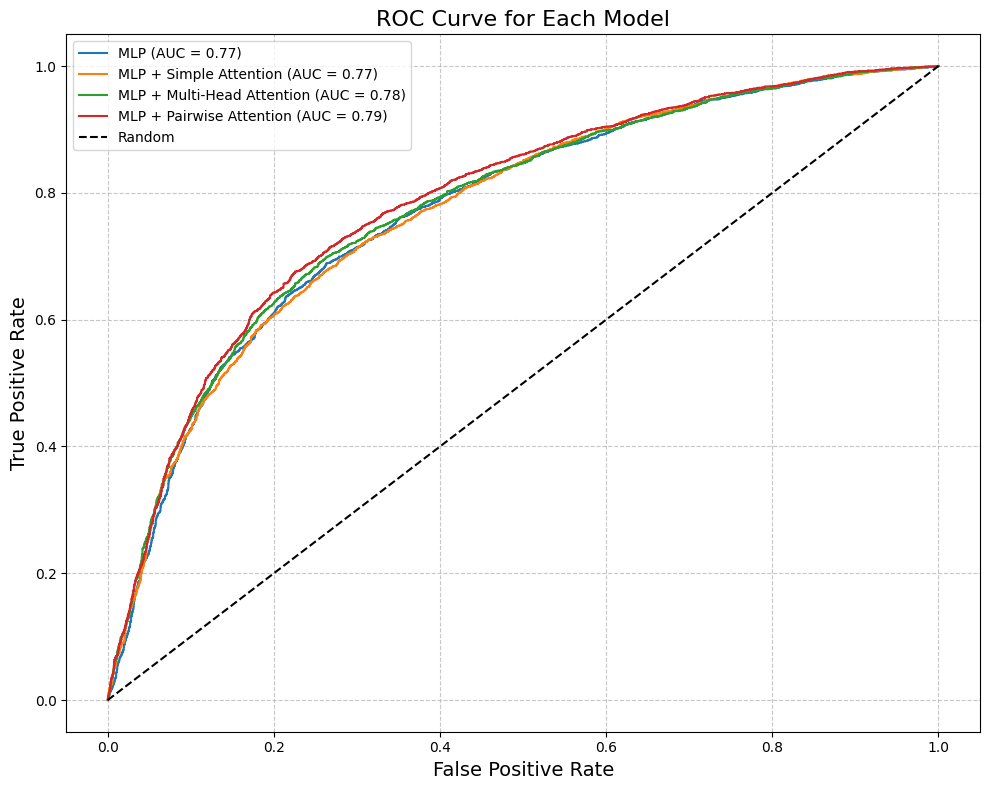

In [27]:
#ROC Curve
plt.figure(figsize=(10, 8))
for model_name, metrics in model_metrics.items():
    fpr, tpr = metrics["roc_curve"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {metrics['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve for Each Model", fontsize=16)
plt.legend(loc="best")
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()